<center><h1>In the name of Allah</h1></center>

Name: Ehsan Hassanbeygi

Student Number: 402211723

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model. 

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [3]:
# Prepare Cifar10 data
batch_size = 128
num_workers = 2
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
################################ End #########################################

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

100%|██████████| 170498071/170498071 [00:06<00:00, 28020017.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# model architecture
class Resnet(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits


##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = Resnet(len(classes)).to(device)

################################ End #########################################

In [5]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [6]:
# ##############################################################################
# # Implement train loop and log training loss after each epoch                #
# ##############################################################################

def train_model(model, trainloader, attack=None):
    model.train()
    for epoch in range(epochs):
        n_correct = 0
        running_loss = 0
        for X, y in trainloader:
            X = X.to(device)
            y = y.to(device)

            if attack is not None:
                X = attack(X, y)

            y_hat = model(X)
            loss = criterion(y_hat, y)
            y_pred = y_hat.argmax(dim=1)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            n_correct += torch.sum(torch.eq(y_pred, y))

        loss = running_loss / len(trainloader)
        acc = n_correct / len(trainloader.dataset)
        print(
            f"Epoch [{epoch+1}/{epochs}], Training Loss= {loss:.4f}, Training Acc= {acc:.4f}"
        )

train_model(model, trainloader)

# ################################ End #########################################

# Save model
model_name = "resnet18_cifar10_model_pretrained.pth"
# model_PATH = f"/kaggle/input/dl-hw5-adversarial-training-resnet-model/{model_name}"
model_PATH = f"{model_name}"
model.eval()
torch.save(model.state_dict(), model_PATH)

Epoch [1/100], Training Loss= 1.5120, Training Acc= 0.4588
Epoch [2/100], Training Loss= 1.0966, Training Acc= 0.6126
Epoch [3/100], Training Loss= 0.9026, Training Acc= 0.6825
Epoch [4/100], Training Loss= 0.7620, Training Acc= 0.7312
Epoch [5/100], Training Loss= 0.6408, Training Acc= 0.7719
Epoch [6/100], Training Loss= 0.5361, Training Acc= 0.8105
Epoch [7/100], Training Loss= 0.4417, Training Acc= 0.8446
Epoch [8/100], Training Loss= 0.3626, Training Acc= 0.8718
Epoch [9/100], Training Loss= 0.2913, Training Acc= 0.8965
Epoch [10/100], Training Loss= 0.2436, Training Acc= 0.9126
Epoch [11/100], Training Loss= 0.1956, Training Acc= 0.9297
Epoch [12/100], Training Loss= 0.1616, Training Acc= 0.9429
Epoch [13/100], Training Loss= 0.1329, Training Acc= 0.9529
Epoch [14/100], Training Loss= 0.1212, Training Acc= 0.9578
Epoch [15/100], Training Loss= 0.0934, Training Acc= 0.9676
Epoch [16/100], Training Loss= 0.0799, Training Acc= 0.9727
Epoch [17/100], Training Loss= 0.0748, Training A

In [7]:
# load the saved model
model = Resnet(len(classes)).to(device)
model.load_state_dict(torch.load(model_PATH))
model = model.to(device)

In [8]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
def eval_model(model, testloader, attack=None):
    model.eval()
    n_correct = 0
    running_loss = 0
    for X, y in testloader:
        X = X.to(device)
        y = y.to(device)

        if attack is not None:
            X = attack(X, y)

        with torch.no_grad():
            y_hat = model(X)
        loss = criterion(y_hat, y)
        y_pred = y_hat.argmax(dim=1)

        running_loss += loss.item()
        n_correct += torch.sum(torch.eq(y_pred, y))

    loss = running_loss / len(testloader)
    acc = n_correct / len(testloader.dataset)

    return loss, acc


loss, acc = eval_model(model, testloader)
print(f"Test Loss= {loss:.4f}, Test Acc= {acc:.4f}")


################################ End #########################################

Test Loss= 2.1508, Test Acc= 0.7515


## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [ ]:
!pip install torchattacks

In [10]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255, 4/255, 8/255               #
##############################################################################
import torchattacks

for epsilon in (1 / 255, 4 / 255, 8 / 255):
    attack = torchattacks.FGSM(model, eps=epsilon)
    loss, acc = eval_model(model, testloader, attack)
    print(
        f"FGSM with epsilon= {epsilon:.4f} model acc= {acc:.4f}, model loss= {loss:.4f}"
    )

################################ End #########################################

FGSM with epsilon= 0.0039 model acc= 0.5333, model loss= 5.4196
FGSM with epsilon= 0.0157 model acc= 0.2355, model loss= 15.6671
FGSM with epsilon= 0.0314 model acc= 0.1192, model loss= 23.3709


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

In [11]:
# vectorized version
class LinfPGDAttack(object):

    def __init__(self, model, epsilon=8 / 255, k=2, alpha=2 / 255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, images, label):

        images = images.to(device)
        label = label.to(device)

        out = self.model(images)
        pred = out.argmax(dim=1)
        perturbed_images = images.clone()
        perturbed_images.to(device)

        # just perturb the samples that are correctly classified
        pert_imgs = perturbed_images[pred == label]
        pert_labels = label[pred == label]
        pert_indices = torch.nonzero(pred == label, as_tuple=True)[0]

        ##############################################################################
        # Implement a k step PGD attack of size alpha                                #
        # while always staying within epsilon distance from the initial point        #
        # Use cross entropy loss                                                     #
        ##############################################################################

        for _ in range(self.steps):
            pert_imgs.requires_grad = True
            y_hat = self.model(pert_imgs)
            loss = F.cross_entropy(y_hat, pert_labels)
            loss.backward()
            self.model.zero_grad()

            # perturbed_images.grad is the gradient of loss w.r.t perturbed_image
            gradient_sign = pert_imgs.grad.sign()
            pert_imgs = pert_imgs + self.alpha * gradient_sign

            # projection on epsilon ball
            pert_imgs = torch.max(
                torch.min(pert_imgs, images[pred == label] + self.epsilon),
                images[pred == label] - self.epsilon,
            )
            pert_imgs = torch.clamp(pert_imgs, 0, 1)
            pert_imgs = pert_imgs.detach()

        perturbed_images[pert_indices] = pert_imgs

        return perturbed_images

In [12]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

for k in (2, 4, 8):
    attack = LinfPGDAttack(model, k=k)
    loss, acc = eval_model(model, testloader, attack)
    print(f"PGD with k= {k} model acc= {acc:.4f}, model loss= {loss:.4f}")

################################ End #########################################

PGD with k= 2 model acc= 0.1662, model loss= 12.3939
PGD with k= 4 model acc= 0.0336, model loss= 25.8139
PGD with k= 8 model acc= 0.0098, model loss= 32.5641


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [13]:
##############################################################################
# Implement the function described                                           #
##############################################################################
import matplotlib.pyplot as plt


def plot_images(orig_img, orig_label, pert_img, pred_label):
    pert = orig_img - pert_img

    _, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax[0].imshow(orig_img.squeeze().detach().cpu().permute(1, 2, 0).numpy())
    ax[0].set_title(f"original image\nlabel: {classes[orig_label]}")
    ax[0].axis("off")

    ax[1].imshow(pert_img.squeeze().detach().cpu().permute(1, 2, 0).numpy())
    ax[1].set_title(f"adversarial image\nlabel: {classes[pred_label]}")
    ax[1].axis("off")

    ax[2].imshow(100 * pert.squeeze().detach().cpu().permute(1, 2, 0).numpy())
    ax[2].set_title("perturbation")
    ax[2].axis("off")

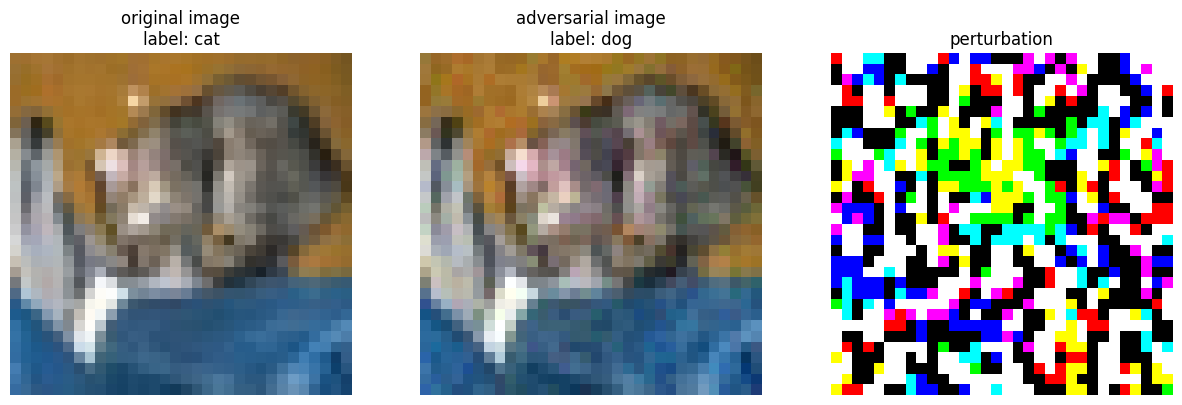

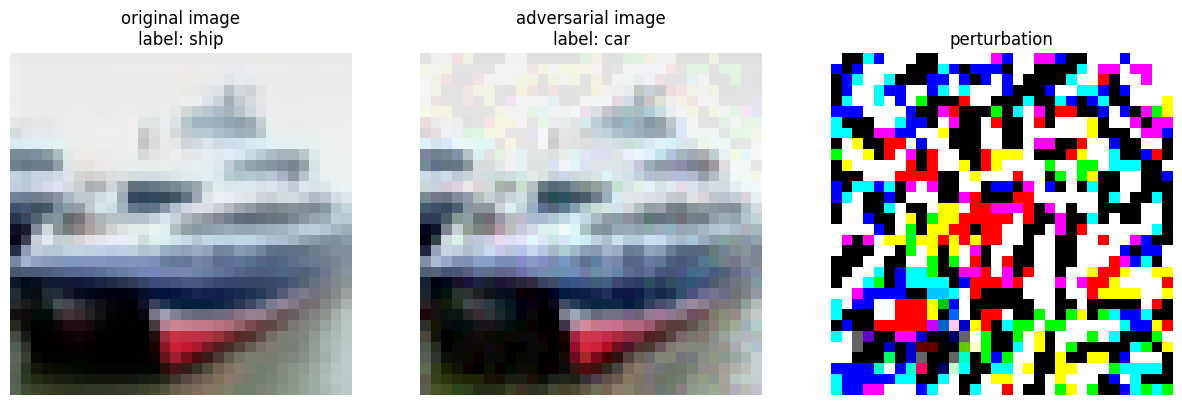

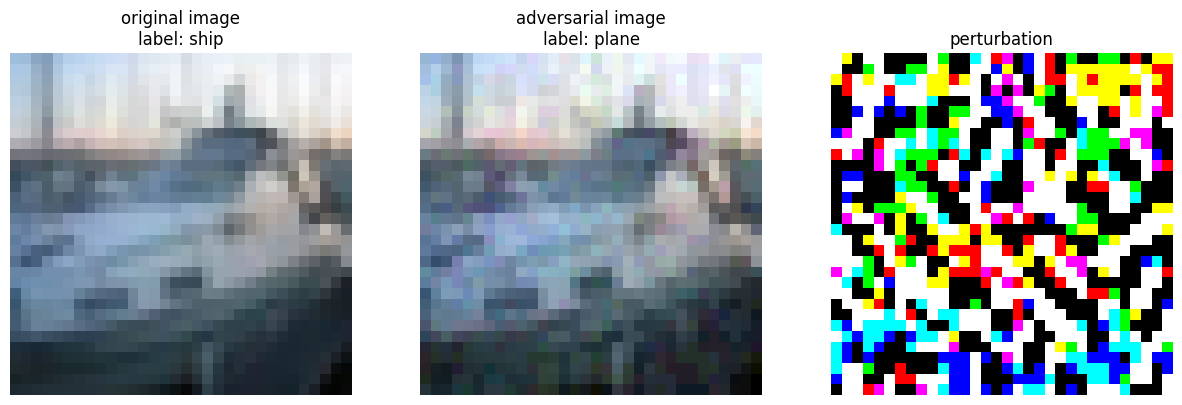

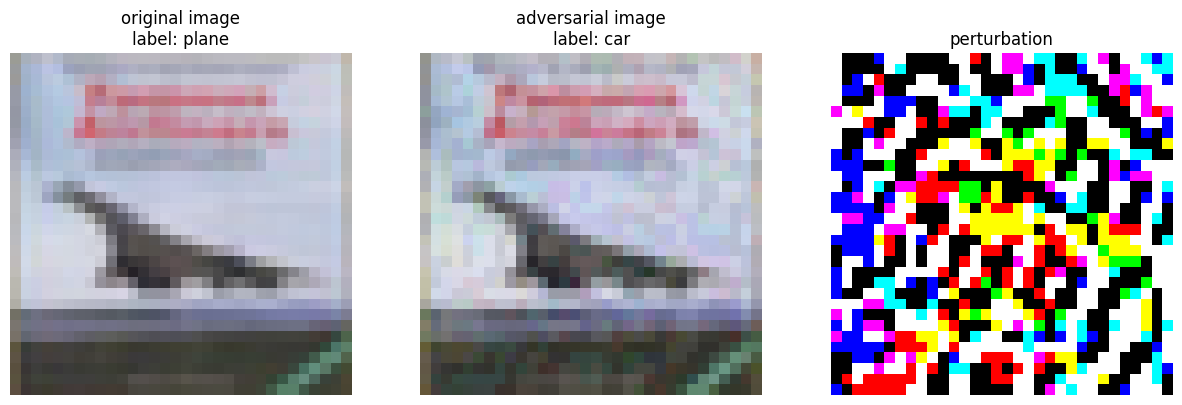

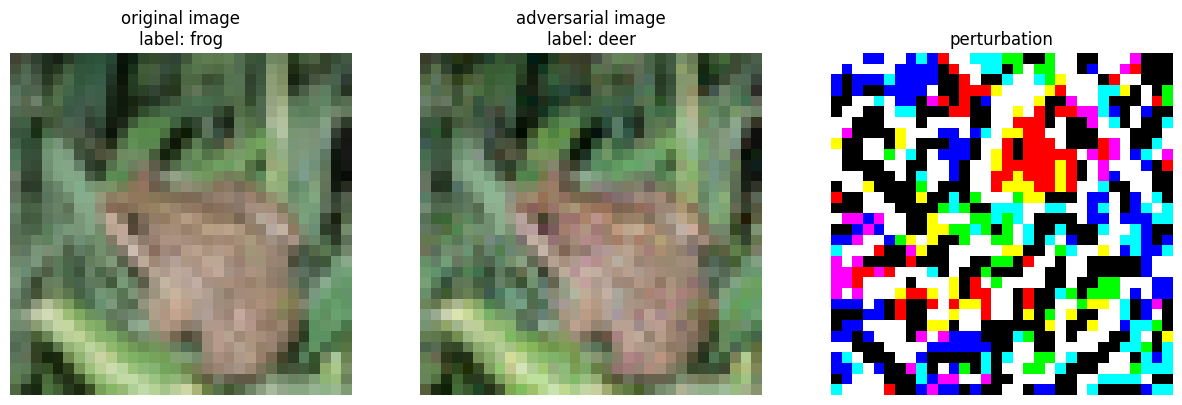

In [14]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################

epsilon = 8 / 255
sample_count = 5
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)
sample_list = []

model.eval()
for X, y in testloader:
    if len(sample_list) >= sample_count:
        sample_list = sample_list[:sample_count]
        break
    X = X.to(device)
    y = y.to(device)
    X_adv = fgsm_attack(X, y)
    with torch.no_grad():
        y_hat = model(X_adv)

    y_pred = y_hat.argmax(dim=1)
    sample_list += list(
        zip(X[y_pred != y], y[y_pred != y], X_adv[y_pred != y], y_pred[y_pred != y])
    )


for s in sample_list:
    plot_images(*s)

################################ End #########################################

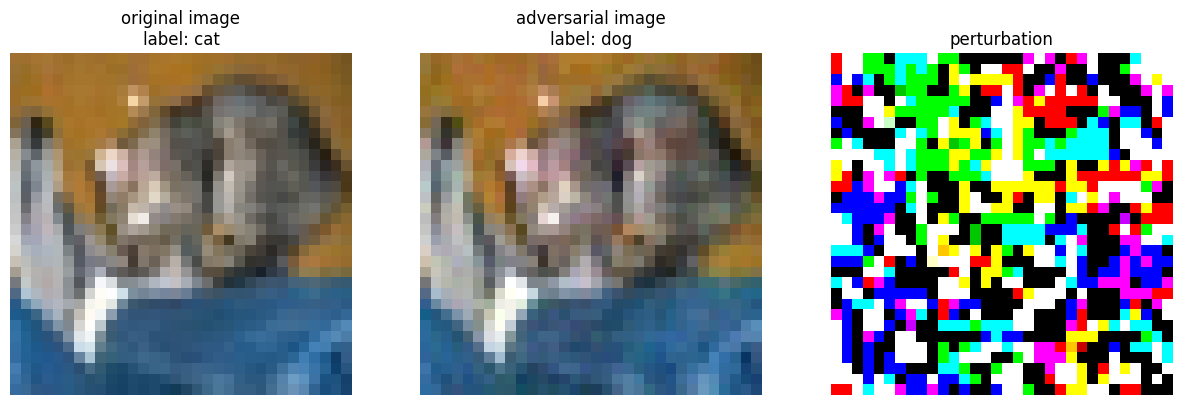

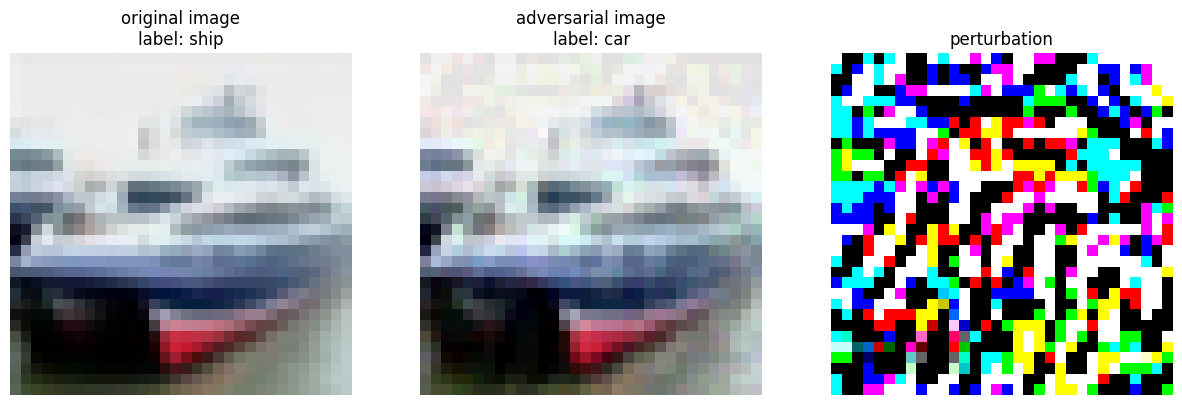

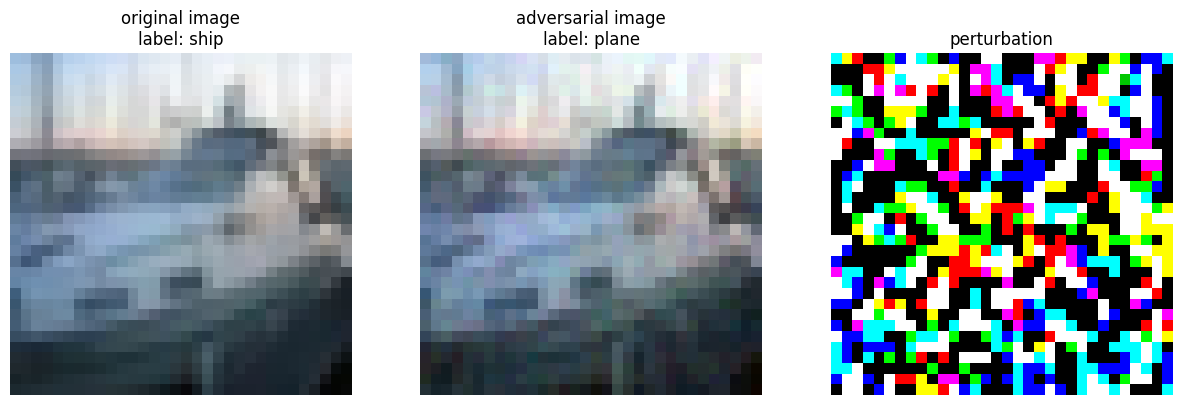

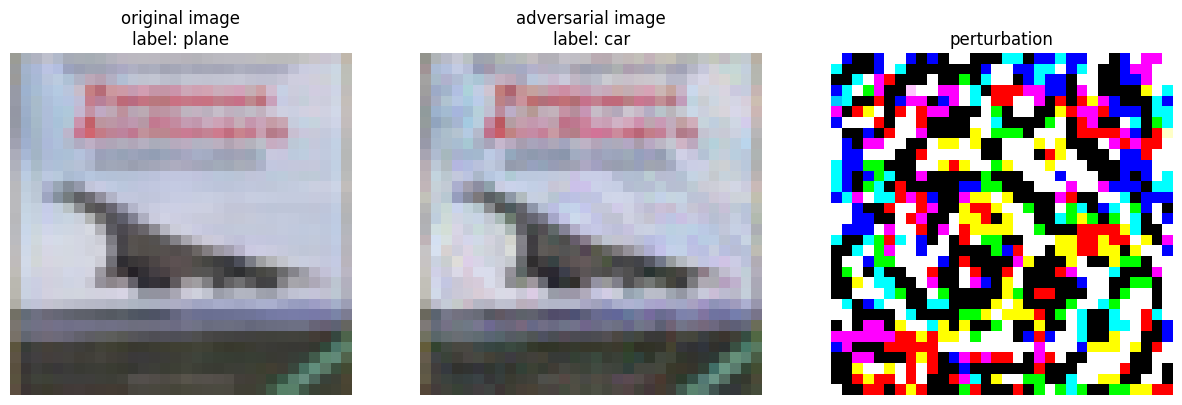

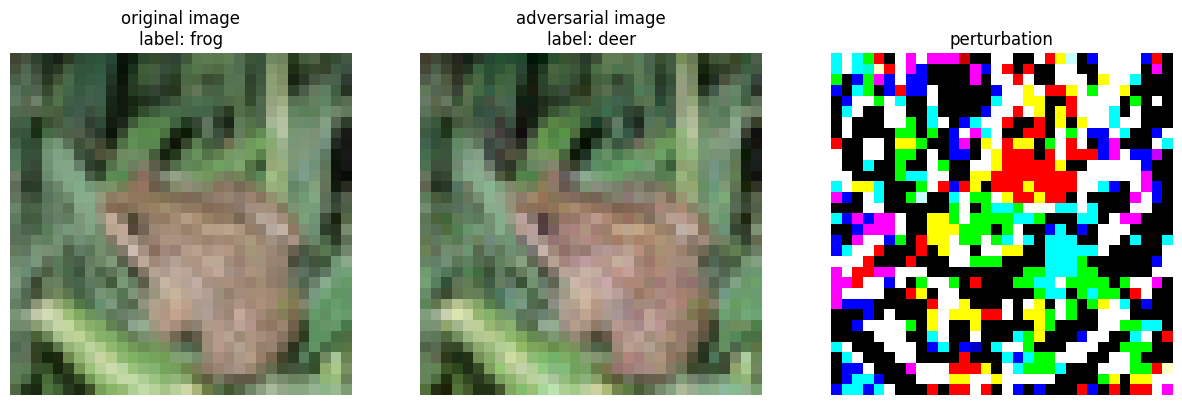

In [15]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

k = 8
sample_count = 5
pgd_attack = LinfPGDAttack(model, k=k)
sample_list = []

model.eval()
for X, y in testloader:
    if len(sample_list) >= sample_count:
        sample_list = sample_list[:sample_count]
        break
    X = X.to(device)
    y = y.to(device)
    X_adv = pgd_attack(X, y)
    with torch.no_grad():
        y_hat = model(X_adv)

    y_pred = y_hat.argmax(dim=1)
    sample_list += list(
        zip(X[y_pred != y], y[y_pred != y], X_adv[y_pred != y], y_pred[y_pred != y])
    )


for s in sample_list:
    plot_images(*s)

################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results. 

In [16]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = Resnet(len(classes)).to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100


# Your code goes here
epsilon = 8 / 255
fgsm_attack = torchattacks.FGSM(adv_model, eps=epsilon)
train_model(adv_model, trainloader, attack=fgsm_attack)

################################ End #########################################

Epoch [1/100], Training Loss= 2.1316, Training Acc= 0.2161
Epoch [2/100], Training Loss= 2.0018, Training Acc= 0.2546
Epoch [3/100], Training Loss= 1.9390, Training Acc= 0.2771
Epoch [4/100], Training Loss= 1.8905, Training Acc= 0.2944
Epoch [5/100], Training Loss= 1.8479, Training Acc= 0.3074
Epoch [6/100], Training Loss= 1.8217, Training Acc= 0.3158
Epoch [7/100], Training Loss= 1.7871, Training Acc= 0.3251
Epoch [8/100], Training Loss= 1.7529, Training Acc= 0.3338
Epoch [9/100], Training Loss= 1.7199, Training Acc= 0.3485
Epoch [10/100], Training Loss= 1.6877, Training Acc= 0.3553
Epoch [11/100], Training Loss= 1.6547, Training Acc= 0.3649
Epoch [12/100], Training Loss= 1.6197, Training Acc= 0.3753
Epoch [13/100], Training Loss= 1.5842, Training Acc= 0.3821
Epoch [14/100], Training Loss= 1.5514, Training Acc= 0.3961
Epoch [15/100], Training Loss= 1.5149, Training Acc= 0.4046
Epoch [16/100], Training Loss= 1.4717, Training Acc= 0.4173
Epoch [17/100], Training Loss= 1.4337, Training A

In [17]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

loss, acc = eval_model(adv_model, testloader)
print(f"Test Loss= {loss:.4f}, Test Acc= {acc:.4f}")

################################ End #########################################

Test Loss= 2.5508, Test Acc= 0.6068


In [18]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

epsilon = 8 / 255
fgsm_attack = torchattacks.FGSM(adv_model, eps=epsilon)

loss, acc = eval_model(adv_model, testloader, attack=fgsm_attack)
print(f"Test Loss= {loss:.4f}, Test Acc= {acc:.4f}")

################################ End #########################################

Test Loss= 8.0724, Test Acc= 0.2292


In [19]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

k = 4
pgd_attack = LinfPGDAttack(adv_model, k=k)

loss, acc = eval_model(adv_model, testloader, attack=pgd_attack)
print(f"Test Loss= {loss:.4f}, Test Acc= {acc:.4f}")

################################ End #########################################

Test Loss= 5.0198, Test Acc= 0.1857


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?

    The accuracy of the adversarially trained model on the clean CIFAR-10 dataset decreased from 75% to 60%. This drop in performance is because adversarial training focuses on enhancing the model's robustness against adversarial examples. As a result, the model may not generalize as well to clean inputs since its training process emphasizes resisting perturbations rather than optimizing for clean accuracy.
    
</br>

- What do you conclude from the result of the FGSM attack on the adversarially trained model?

    The model trained only on the clean dataset had its accuracy reduced to 12% when subjected to the FGSM attack. In contrast, the adversarially trained model achieved an accuracy of 23% under the same attack. This indicates that the adversarially trained model is somewhat more robust to the FGSM attack. This is due to the model's exposure to adversarial examples during training, which helps it learn to resist perturbations like those generated by the FGSM attack.

</br>

- What do you conclude from the result of the PGD attack on the adversarially trained model?

    The model trained only on the clean dataset had its accuracy reduced to 3.3% when subjected to the PGD attack. In contrast, the adversarially trained model achieved an accuracy of 18.5% under the same attack. This indicates that the adversarially trained model is somewhat more robust to the PGD attack as well. The adversarially trained model's better performance under this attack further confirms that adversarial training effectively enhances resistance to stronger adversarial perturbations.

</br>

- What is you final conclusion?

    We can see that adversarial training is a tradeoff between robustness of the model to adversarial attacks and the overal performance on clean inputs. Although it enhances the model's resistance to adversarial attacks, as evidenced by the increased accuracy under FGSM and PGD attacks, it simultaneously leads to a decline in accuracy on clean data.
    Moreover, despite the gains in robustness, adversarial training does not make models completely immune to attacks. There is still an ongoing debate and research on how to improve the robustness further without sacrificing too much performance on clean data.
    Some also claim that even by ignoring the performance drop of the model on clean inputs, adversarial training, still doesn't achieve sufficient robustness against adversarial attacks.